# Predicting Ice-Philicity of Protein Atoms


University of Pennsylvania, CIS 5450 Final Project

*Work done by : Sabrina Weng, Ji Hyun Kim, Jeongmoon Choi*


##I. Introduction and Background

**Problem Statement**

Ice-philicity, the tendency of proteins or their atomic components to bind to ice, is a critical phenomenon influencing a variety of biological and technological applications, including cryopreservation, antifreeze materials, and organ transplantation. Despite its importance, understanding what drives ice-philicity at the atomic level remains a challenging task.

Our goal in this project is to address this challenge by predicting the ice-philicity of protein atoms based on their structural and chemical features. Specifically, we aim to identify the most significant features affecting ice-philicity and evaluate whether it can be reliably predicted from protein structure alone.

\\
**Objective and Value Proposition**

The primary objective of this project is to develop a predictive model for ice-philicity using chemical and structural data of protein atoms. By achieving this, we aim to:

*   Identify key determinants of ice-philic behavior, providing insights into protein-ice interactions.

*   Establish a reliable predictive framework for ice-philicity that could assist in the design of custom materials or surfaces mimicking or repelling ice-binding proteins.

*   Explore how predictive modeling can contribute to advancements in biomaterials, cryopreservation techniques, and antifreeze technologies.



##II. Data Loading, Preprocessing and Exploratory Data Analysis (EDA)

###Read and Load Data

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import ttest_ind, pearsonr, chi2_contingency
from scipy.spatial.distance import pdist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have 10 potein dataset, including 6 antifreeze protein and 4 normal protein. Each file contains different numbers of protein data. Therefore, we check whether all dataset have the same columns and combine all 10 files together, creating a single dataframe.

In [ ]:
data_dir = '/content/drive/MyDrive/CIS545/data'

# Load all CSV files from the directory
all_files = glob.glob(os.path.join(data_dir, "*.csv"))

expected_columns = [
    "atom_number", "atom_name", "resname", "charge", "x", "y", "z",
    "protein_name", "betaphi", "ice_philic", "neighbor"
]

# Combine all files into a single DataFrame
df_list = []
for file in all_files:
  df = pd.read_csv(file)
  file_name = os.path.basename(file)

  if sorted(df.columns) != sorted(expected_columns):
        raise ValueError(f"File '{file_name}' does not match the expected columns!")

  df = df[expected_columns]
  df_list.append(df)
  print(f'Protein Data "{file_name}" have shape {df.shape}')

Protein Data "SBWAFP.csv" have shape (9334, 11)
Protein Data "TMAFP.csv" have shape (5804, 11)
Protein Data "LPAFP.csv" have shape (8416, 11)
Protein Data "OPAFP.csv" have shape (6144, 11)
Protein Data "TISAFP.csv" have shape (13324, 11)
Protein Data "hepatitis.csv" have shape (18906, 11)
Protein Data "hydrophobin.csv" have shape (8224, 11)
Protein Data "ubiquitin.csv" have shape (10310, 11)
Protein Data "barnase.csv" have shape (14872, 11)
Protein Data "COLAFP.csv" have shape (14348, 11)


In [ ]:
# combine all protein data into a single DataFrame
data = pd.concat(df_list, ignore_index=True)
print(f'Data shape of the combined dataset: {data.shape}')
data.head(5)

Data shape of the combined dataset: (109682, 11)


,atom_number,atom_name,resname,charge,x,y,z,protein_name,betaphi,ice_philic,neighbor
0,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,1
1,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,2
2,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,3
3,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,4
4,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,5


### Data Integrity


Before modeling, we conducted an exploratory data analysis (EDA) to understand the dataset and address key challenges. We go through checking data type, missing values and duplicates.

According to the analysis below, we ensure that there are no missing values or duplicate entries were found, ensuring data completeness and integrity.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109682 entries, 0 to 109681
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   atom_number   109682 non-null  int64  
 1   atom_name     109682 non-null  object 
 2   resname       109682 non-null  object 
 3   charge        109682 non-null  float64
 4   x             109682 non-null  float64
 5   y             109682 non-null  float64
 6   z             109682 non-null  float64
 7   protein_name  109682 non-null  object 
 8   betaphi       109682 non-null  float64
 9   ice_philic    109682 non-null  bool   
 10  neighbor      109682 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 8.5+ MB


In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values.rename('Missing Value Count', inplace = True)

missing_values

,Missing Value Count
atom_number,0
atom_name,0
resname,0
charge,0
x,0
y,0
z,0
protein_name,0
betaphi,0
ice_philic,0


In [ ]:
# Check the data types of each columns
data_type = data.dtypes
data_type.rename('Data Type', inplace = True)

data_type

,Data Type
atom_number,int64
atom_name,object
resname,object
charge,float64
x,float64
y,float64
z,float64
protein_name,object
betaphi,float64
ice_philic,bool


In [ ]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [ ]:
# Create 'absolute_charge'
data['absolute_charge'] = data['charge'].abs()

In [ ]:
# check the dataset after adding "absolute_charge" column
data.head(5)

,atom_number,atom_name,resname,charge,x,y,z,protein_name,betaphi,ice_philic,neighbor,absolute_charge
0,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,1,0.2943
1,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,2,0.2943
2,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,3,0.2943
3,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,4,0.2943
4,0,N,GLY,0.2943,27.95,23.369999,32.23,SBWAFP,2.04,False,5,0.2943


### Class Imbalance

We later discovered that this dataset is heavily imbalanced, with only 11.34% (12,442) ice-philic atoms compared to 88.66% (97,240) non-ice-philic atoms.

In [ ]:
# Convert ice_philic column into numerical
# if ice_philic = False, set ice_philic = 0
# if ice_philic = True, set ice_philic = 1
# data['ice_philic'] = data['ice_philic'].astype(int)

data_imbalane = data['ice_philic'].value_counts()
data_imbalane.rename('Data Imbalance Count', inplace = True)
data_imbalane

,Data Imbalance Count
ice_philic,
False,97240
True,12442


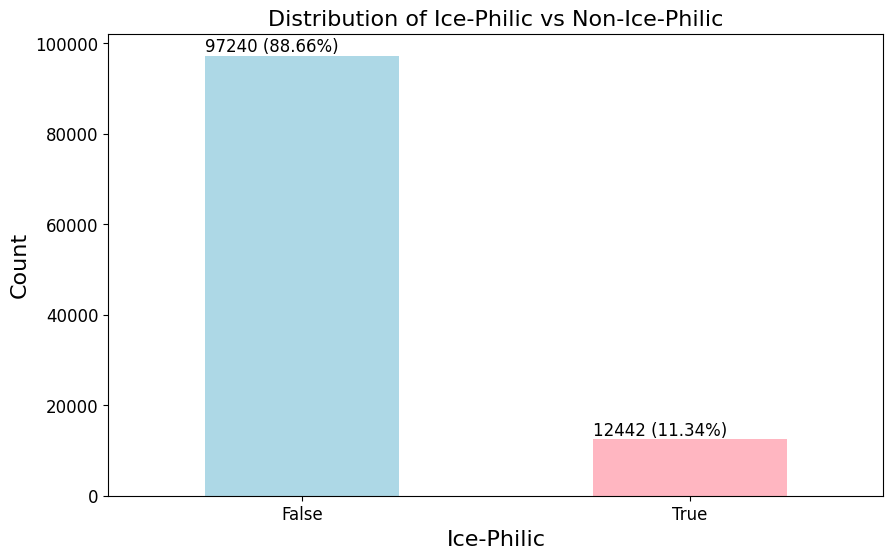

In [ ]:
# Plot the distribution of 'ice_philic'
plt.figure(figsize = (10, 6))
ax = data['ice_philic'].value_counts().plot(kind='bar', color=['lightblue', 'lightpink'], fontsize=12 )
for p in ax.patches:
    ax.annotate(f"{p.get_height()} ({p.get_height() / data.shape[0] * 100:.2f}%)",
                (p.get_x(), p.get_height() + 1000), fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Distribution of Ice-Philic vs Non-Ice-Philic', fontsize=16)
plt.xlabel('Ice-Philic', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

### Feature Engineering

Encoding Categorical Features & Scaling Numerical Features

*   Categorical Features

    *   To incorporate categorical variables into the modeling process, we applied one-hot encoding to the categorical features.
    
    *   One-hot encoding transforms these categorical variables into binary indicator columns, ensuring they are represented numerically without introducing ordinal assumptions. This step allows models to interpret these categorical variables effectively.

*   Numerical Features Numerical
    *   To ensure that numerical features are on a comparable scale, we applied standardization to all numerical features. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, which is crucial for models sensitive to feature magnitudes (e.g., SVM, Logistic Regression, and Gradient Boosting). This step improves convergence during training and prevents features with larger ranges from dominating the model's learning process.

In [ ]:
# Separate X(features) and y(target)
X = data.drop(columns=['ice_philic'])
y = data['ice_philic']

In [ ]:
# Split data into training and testing sets before preprocessing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reset indices
X_train_raw.reset_index(drop=True, inplace=True)
X_test_raw.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
# Identify numeric and categorical columns
numeric_columns = ['atom_number', 'charge', 'x', 'y', 'z', 'betaphi', 'neighbor', 'absolute_charge']
categorical_columns = ['atom_name', 'resname', 'protein_name']

In [ ]:
# One-hot encode categorical columns
encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore')

# Training data
X_train_cat = encoder.fit_transform(X_train_raw[categorical_columns])
X_train_cat = pd.DataFrame(X_train_cat, columns=encoder.get_feature_names_out(categorical_columns))

# Test data
X_test_cat = encoder.transform(X_test_raw[categorical_columns])
X_test_cat = pd.DataFrame(X_test_cat, columns=encoder.get_feature_names_out(categorical_columns))

In [ ]:
# Scale numerical features
scaler = StandardScaler()

# Training data
X_train_num = scaler.fit_transform(X_train_raw[numeric_columns])
X_train_num = pd.DataFrame(X_train_num, columns=numeric_columns)

# Test data
X_test_num = scaler.transform(X_test_raw[numeric_columns])
X_test_num = pd.DataFrame(X_test_num, columns=numeric_columns)

In [ ]:
# Combine data

# Training data
X_train_preprocessed = pd.concat([X_train_num, X_train_cat], axis=1)

# Test data
X_test_preprocessed = pd.concat([X_test_num, X_test_cat], axis=1)

### Application for Class imbalance

Class imbalance poses a challenge as models trained on imbalanced data often develop a bias toward the majority class, leading to poor performance in predicting the minority class.

To address this, we applied SMOTE (Synthetic Minority Oversampling Technique) to the training set. SMOTE generates synthetic samples for the minority class by interpolating between existing samples, effectively balancing the dataset. This ensures fair representation of both classes during model training, improving the model's ability to predict ice-philic atoms accurately.

In [ ]:
# Apply to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Balancing check after SMOTE
y_train_smote.value_counts()

,count
ice_philic,
True,68131
False,68131


In [ ]:
balanced_data = X_train_smote.copy()
balanced_data['ice_philic'] = y_train_smote
balanced_data.head(5) # original shape (109682, 11) now we have (136262, 74)

,atom_number,charge,x,y,z,betaphi,neighbor,absolute_charge,atom_name_CA,atom_name_CB,...,protein_name_LPAFP,protein_name_OPAFP,protein_name_SBWAFP,protein_name_TISAFP,protein_name_TMAFP,protein_name_barnase,protein_name_hepatitis,protein_name_hydrophobin,protein_name_ubiquitin,ice_philic
0,-0.216326,0.725563,-0.616262,1.068524,0.990650,-2.231082,-0.427835,-0.615541,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,1.074413,-0.463889,2.002555,1.198248,0.184291,-0.902244,0.534560,-0.211543,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
2,-0.468423,0.326764,1.063831,-0.753120,-0.280202,-0.636477,-0.367371,-1.284486,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
3,0.328205,1.069919,-1.099667,0.625994,-2.285570,-1.965314,0.116346,-0.037918,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,-1.426393,-1.021087,-1.518027,-1.915108,-1.920170,-0.104942,-1.400308,0.723101,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [ ]:
# Check again if there's missing values
balanced_data.isnull().sum()

,0
atom_number,0
charge,0
x,0
y,0
z,0
...,...
protein_name_barnase,0
protein_name_hepatitis,0
protein_name_hydrophobin,0
protein_name_ubiquitin,0


In [ ]:
# Brief summary statistics
balanced_data.describe()

,atom_number,charge,x,y,z,betaphi,neighbor,absolute_charge,atom_name_CA,atom_name_CB,...,resname_VAL,protein_name_LPAFP,protein_name_OPAFP,protein_name_SBWAFP,protein_name_TISAFP,protein_name_TMAFP,protein_name_barnase,protein_name_hepatitis,protein_name_hydrophobin,protein_name_ubiquitin
count,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,...,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.000000,136262.00000
mean,0.044525,-0.001579,0.161365,0.088338,0.021572,-0.636716,0.041771,-0.004612,0.142745,0.143025,...,0.040957,0.065293,0.043600,0.070438,0.089642,0.045031,0.131210,0.260461,0.062563,0.13703
std,1.008428,0.994902,0.938312,0.973308,1.012057,1.222817,1.003928,0.993421,0.349655,0.349821,...,0.198079,0.247044,0.204204,0.255884,0.285423,0.207373,0.337632,0.438888,0.242177,0.34388
min,-1.476812,-1.996129,-2.339965,-2.433081,-2.818188,-4.755873,-1.475889,-1.408504,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-0.760856,-0.680092,-0.566000,-0.662037,-0.710012,-1.433780,-0.764849,-1.082300,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,-0.095319,0.011085,0.150239,0.064780,0.116165,-0.636477,-0.097892,0.151115,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.686183,0.361491,0.884217,0.809078,0.806091,0.293709,0.678886,0.817806,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
max,2.581955,2.234278,3.143066,2.594842,2.717322,9.196918,2.580280,2.358635,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


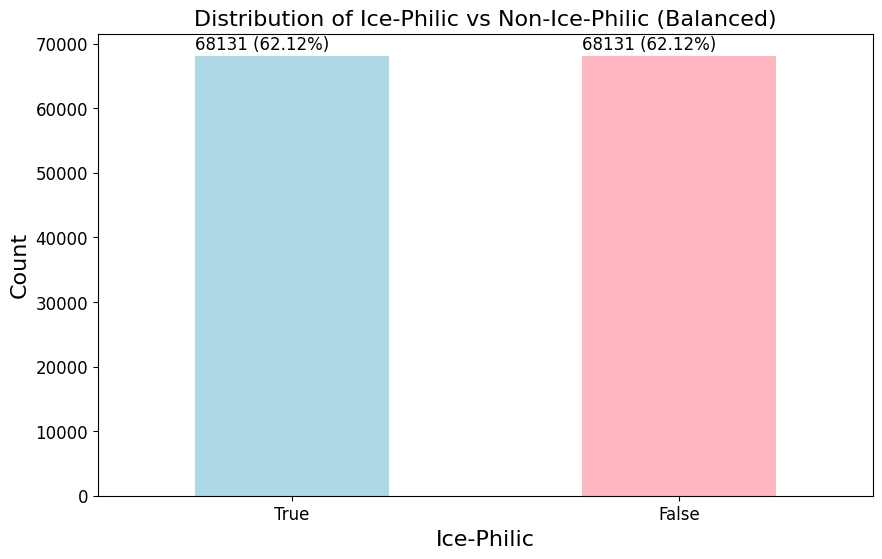

In [ ]:
plt.figure(figsize = (10, 6))
bn = balanced_data['ice_philic'].value_counts().plot(kind = 'bar', color = ['lightblue', 'lightpink'], fontsize=12)
for p in bn.patches:
    bn.annotate(f"{p.get_height()} ({p.get_height() / data.shape[0] * 100:.2f}%)",
                (p.get_x(), p.get_height() + 1000), fontsize=12)

bn.set_xticklabels(bn.get_xticklabels(), rotation=0)
plt.title('Distribution of Ice-Philic vs Non-Ice-Philic (Balanced)', fontsize=16)
plt.xlabel('Ice-Philic', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()


### Visualizations

**1. Distribution of Numerical Features using Histogram (Balanced Data)**

This set of histograms represents the distribution of numerical features in the balanced dataset, providing a clear overview of their frequency distributions after addressing the class imbalance.

We discovered that:

*   Charge and Absolute_Charge: These features display distinct peaks, indicating specific values are more prevalent and may influence the ice-philicity of protein atoms.
*   Spatial Coordinates (x, y, z): These features exhibit approximately normal distributions, suggesting that protein atoms are spatially clustered within certain regions.
*   Betaphi: The distribution shows a strong skew toward lower values, consistent with its importance as a predictor of ice-philicity.
*   Neighbor: The number of neighboring atoms decreases steadily, with fewer atoms having higher numbers of neighbors.





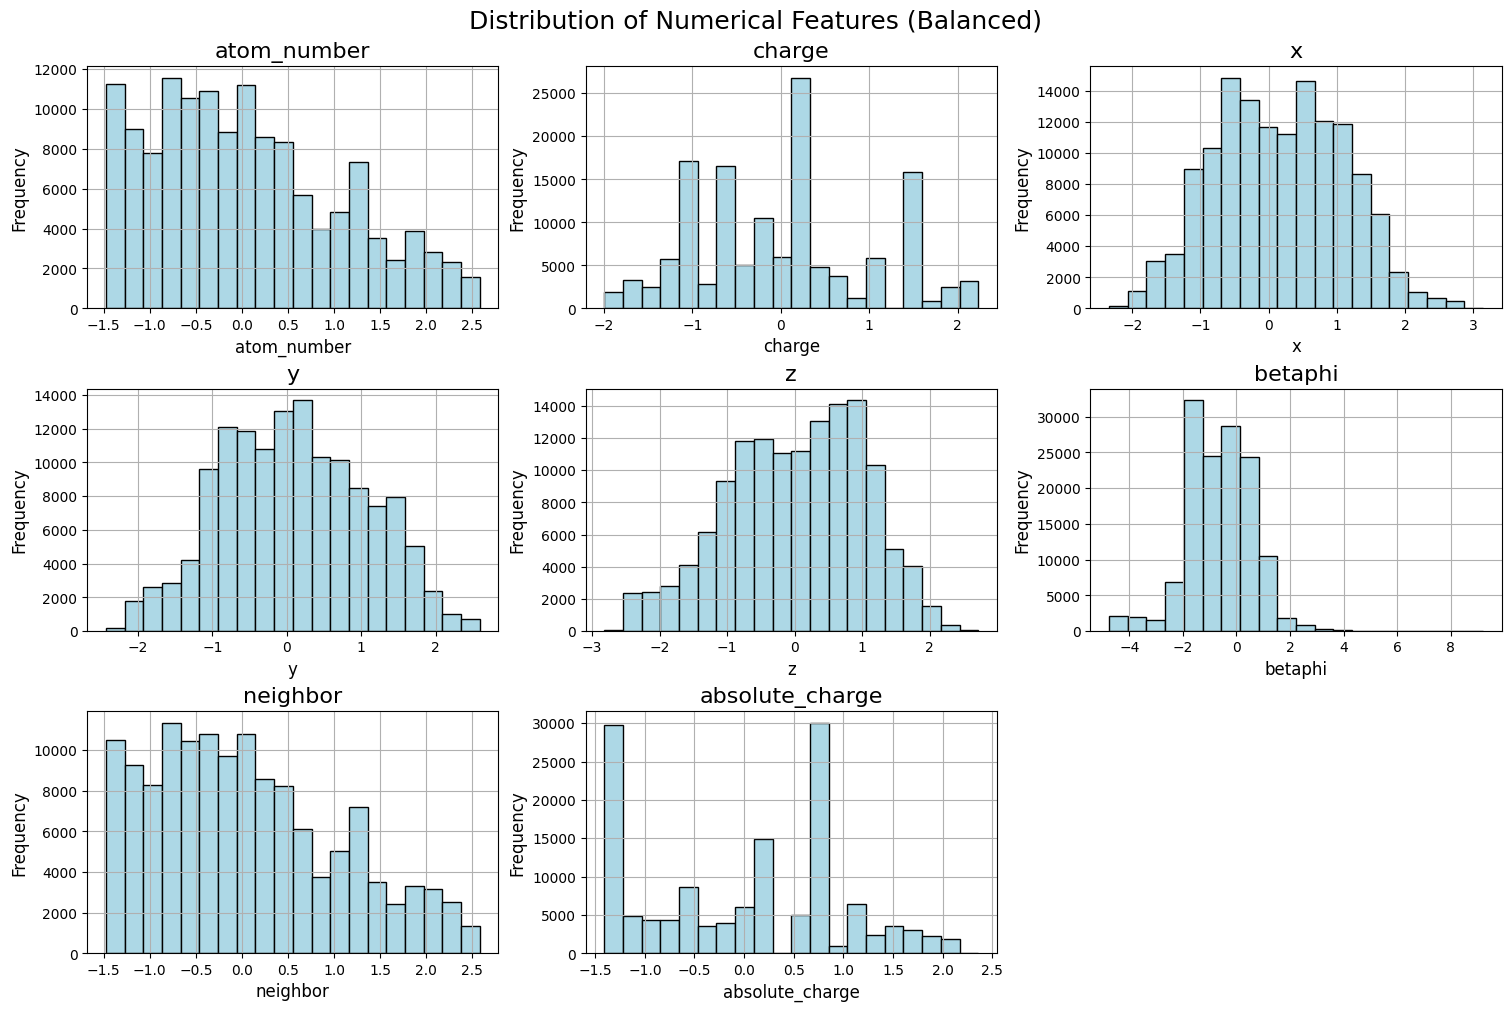

In [ ]:
# Generate subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

# Plot each column
for i, column in enumerate(numeric_columns):
    balanced_data[column].hist(bins=20, ax=axes[i], color='lightblue', edgecolor='black')
    axes[i].set_title(column, fontsize = 16)
    axes[i].set_xlabel(column, fontsize = 12)
    axes[i].set_ylabel('Frequency', fontsize = 12)

# Remove unused subplots (if any)
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

# Add a super title for the figure
fig.suptitle('Distribution of Numerical Features (Balanced)', fontsize=18)
plt.show()

**2. Distribution of Numerical Features by Ice-Philic using Kernel Density Estimate (KDE) Plot**

This visualization uses Kernel Density Estimate (KDE) plots to compare the distribution of numerical features between ice-philic and non-ice-philic atoms after balancing the dataset.

We discovered that:

*   Betaphi: Clear separation between ice-philic (pink) and non-ice-philic (blue) classes. Ice-philic atoms are concentrated at lower betaphi values, confirming its importance as a key predictor.

*   Charge and Absolute Charge: Overlapping distributions with subtle differences in peak values, suggesting moderate influence on ice-philicity.

*   Spatial Coordinates (x, y, z): These features show significant overlap between the two classes, indicating weaker discriminative power for predicting ice-philicity.

*   Neighbor: Slightly different distributions, with ice-philic atoms having a distinct density peak compared to non-ice-philic atoms.

We can conclude that features like betaphi exhibit strong class separation, making them highly valuable for modeling. Overlapping features such as x, y, and z may require interaction terms or advanced techniques to improve their predictive utility. This balanced view ensures fair representation of both classes, guiding feature selection and model refinement.



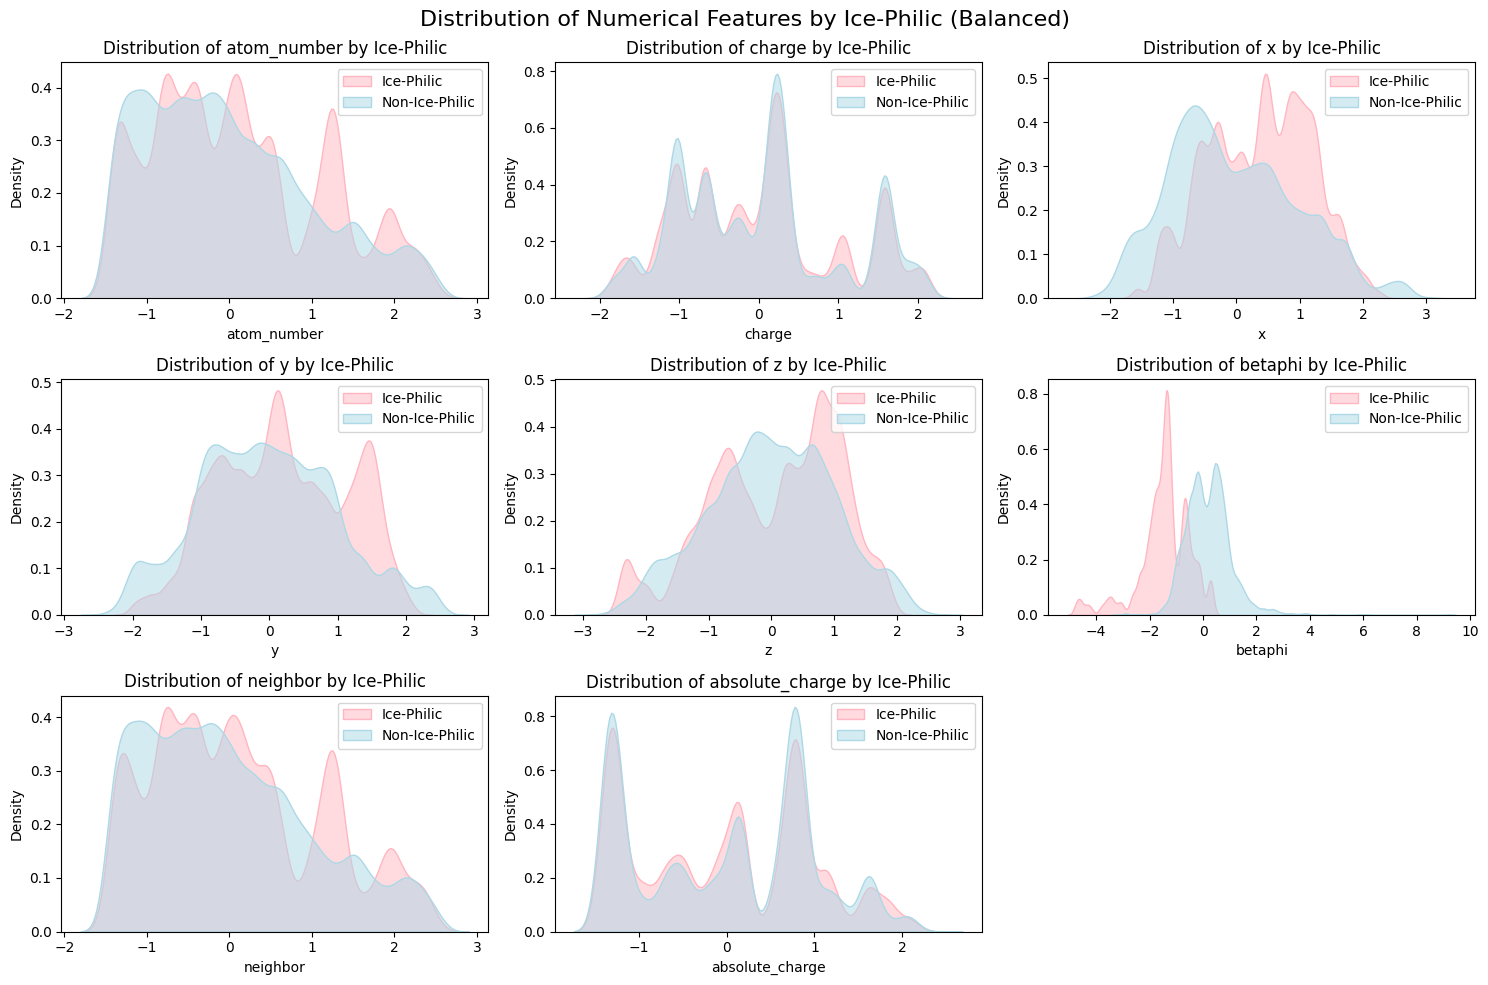

In [ ]:
n_cols = 3
n_rows = -(-len(numeric_columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.kdeplot(balanced_data[balanced_data['ice_philic'] == 1][col], label='Ice-Philic', fill=True, alpha=0.5, color='lightpink', ax=axes[i])
    sns.kdeplot(balanced_data[balanced_data['ice_philic'] == 0][col], label='Non-Ice-Philic', fill=True, alpha=0.5, color='lightblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Ice-Philic')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of Numerical Features by Ice-Philic (Balanced)', fontsize=16)
plt.tight_layout()
plt.show()


**3. Correlation Among Numerical Features**

This correlation matrix provides an overview of the relationships between numerical features and their correlation with the target variable (ice_philic). This correlation analysis helps prioritize features for modeling while identifying potential redundancies and relationships among variables.

We discovered that:

*   Betaphi has the strongest negative correlation with ice_philic (-0.67), indicating it is a highly influential feature for predicting ice-philicity.
*   Features like x (0.22) and atom_number (0.06) show weaker positive correlations, suggesting limited individual predictive power.


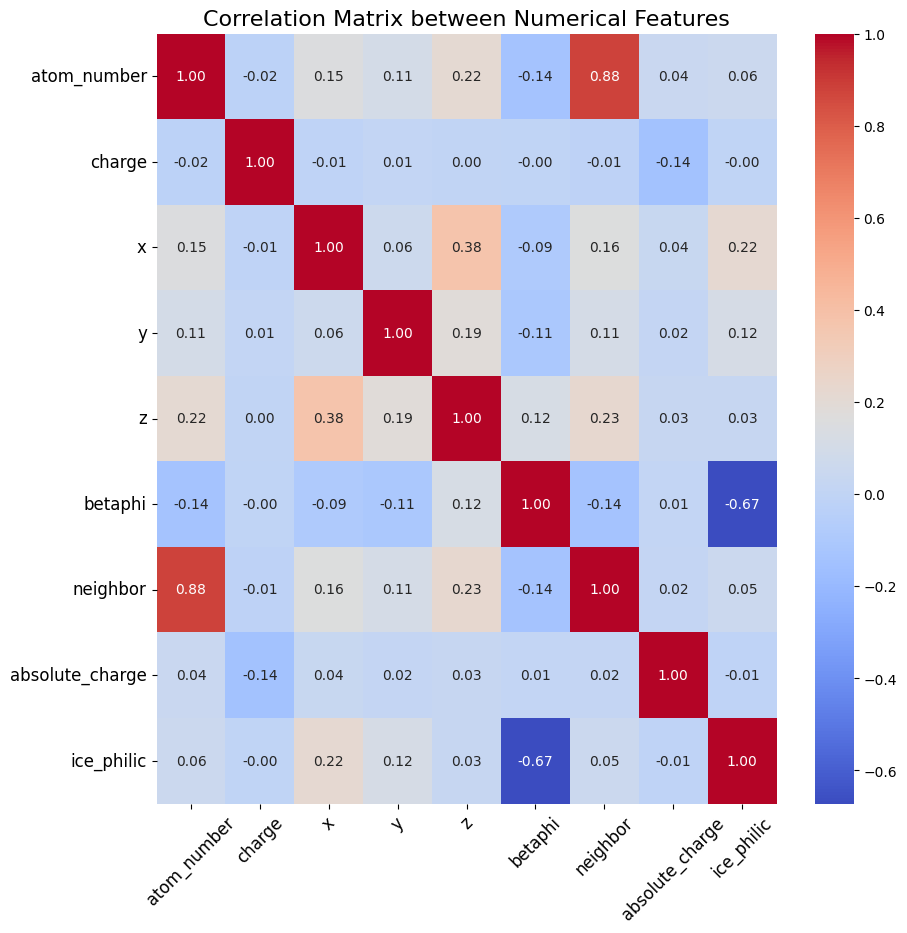

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(balanced_data[numeric_columns].join(balanced_data['ice_philic']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation = 0, fontsize=12)
plt.title('Correlation Matrix between Numerical Features', fontsize = 16)
plt.show()

##III. Model Training and Prediction

###Feature Selection

Our dataset contains the following columns: '*atom_number', 'atom_name', 'resname', 'charge', 'x', 'y', 'z', 'protein_name', 'betaphi', 'ice_philic', 'neighbor', and 'absolute_charge'*. These can be broadly categorized into chemical features and structural or spatial features. While all columns provide valuable information, we chose to focus on chemical features for the following reasons:


*   **Betaphi:** Directly determines ice-philicity and cannot be used as a predictive feature without causing data leakage.
  *   Ice-philic is determined as 1 if 'betaphi' is below a threshold; otherwise, it is 0.

*   **Neighbor:** Contains the unique IDs of nearby atoms for each atom.
  *   As these IDs lack intrinsic meaning, embedding is required to make this feature useful.

*   **Position:** Includes spatial coordinates ('x', 'y', 'z') relevant only within a single protein.
  *   Inter-protein positions hold no significance in this analysis.

By focusing on chemical features like **'charge', 'absolute_charge', 'atom_name', 'resname', and 'protein_name'**, we ensured that our selected features are both meaningful and interpretable, guiding our modeling process without introducing unnecessary complexity.

In [ ]:
# Prepare the data
X_train, X_test, y_train, y_test = X_train_smote, X_test_preprocessed, y_train_smote, y_test

In [ ]:
# Extracting features charge, absolute_charge, atom_name, resname, protein_name
data.drop(columns=['ice_philic'])
columns_to_keep = ['charge', 'absolute_charge'] + \
    [col for col in X_train.columns if col.startswith('atom_name_') or col.startswith('resname_') or col.startswith('protein_name')]

# Filter the training and testing datasets
X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]

In [ ]:
X_train, X_test = X_train_filtered, X_test_filtered

###a. Dummy Classifier (Baseline Model)

The dummy classifier serves as a baseline model to establish a point of reference for evaluating the performance of more complex models. By using simple strategies such as predicting the most frequent class or random guessing, the dummy classifier allows us to determine whether our chosen models meaningfully outperform random or naive predictions. This ensures that any observed improvements in accuracy or other metrics are due to the predictive power of the models and not by chance.

**Most Frequent Classifier** \
This classifier always predicts the most frequent class in the training data. It is commonly used for imbalanced datasets where one class dominates the data.

```
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
```

It turned out 0.88 accuracy under our dataset; however, this classifier is **not suitable** for our case since it's not useful for datast where class distribution is even.

**Uniform Classifier** \
Uniform classifier generates random predictions with uniform probabilities for all classes. This classifier is useful when there is no information about the class distribution in the training data, but it is not suitable for imbalanced datasets.

```
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
```
It turned out 0.5 accuracy under our dataset, it is **suitable** for our case since we are having balanced dataset with even numbers in both classes.

####Prediction and Evaluation

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
# print(accuracy_score(y_test, dummy_pred))

# Classification Report
print("Classification Report for Dummy Uniform Classifier:")
print(classification_report(y_test, dummy_pred, target_names=['Non-Ice-Philic', 'Ice-Philic']))

Classification Report for Dummy Uniform Classifier:
                precision    recall  f1-score   support

Non-Ice-Philic       0.89      0.50      0.64     29109
    Ice-Philic       0.12      0.51      0.19      3796

      accuracy                           0.50     32905
     macro avg       0.50      0.51      0.42     32905
  weighted avg       0.80      0.50      0.59     32905



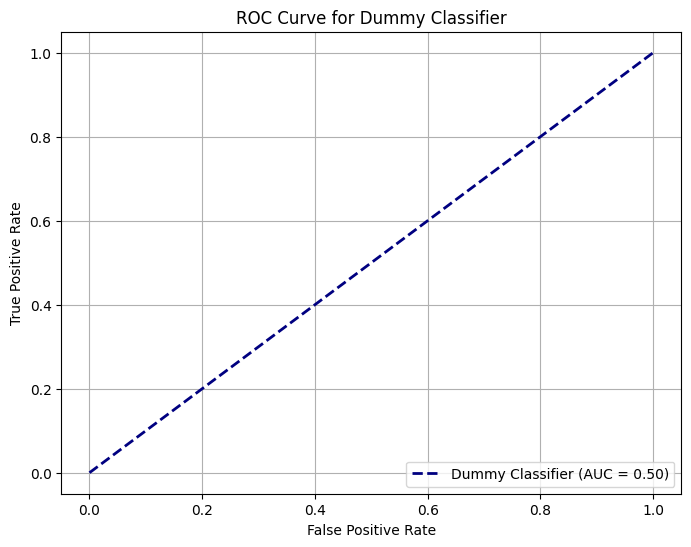

In [ ]:
# ROC Curve

# Probability scores for the positive class
y_scores_lr = dummy_clf.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr_lr,
    tpr_lr,
    color='navy',
    lw=2,
    linestyle='--',
    label='Dummy Classifier (AUC = %0.2f)' % roc_auc_lr
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Dummy Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### b. Logistic Regression

As the first predictive model, **Logistic Regression** was chosen for its simplicity and efficiency. It provides a straightforward approach to evaluate whether the selected chemical features can predict ice-philicity. While it assumes linear relationships between features and the target variable, it serves as an effective benchmark to compare with more complex models.

####Hyperparameter Tuning

To optimize the performance of our models, we utilized **GridSearchCV** for hyperparameter tuning. This method systematically tests all possible combinations of predefined hyperparameters using cross-validation to identify the optimal configuration for each model.

For Logistic Regression, we tuned parameters such as *regularization strength* and *the type of penalty*.

In [ ]:
# Parameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

# Initialize the model
logreg = LogisticRegression(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search_lr = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for Logistic Regression:", grid_search_lr.best_params_)

Best hyperparameters for Logistic Regression: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


####Prediction and Evaluation

In [ ]:
# Retrieve the best estimator
best_logreg = grid_search_lr.best_estimator_

# Make predictions on the preprocessed test data
y_pred_lr = best_logreg.predict(X_test)

# Classification Report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Ice-Philic', 'Ice-Philic']))

Classification Report for Logistic Regression:
                precision    recall  f1-score   support

Non-Ice-Philic       0.95      0.72      0.82     29109
    Ice-Philic       0.25      0.73      0.37      3796

      accuracy                           0.72     32905
     macro avg       0.60      0.72      0.60     32905
  weighted avg       0.87      0.72      0.77     32905



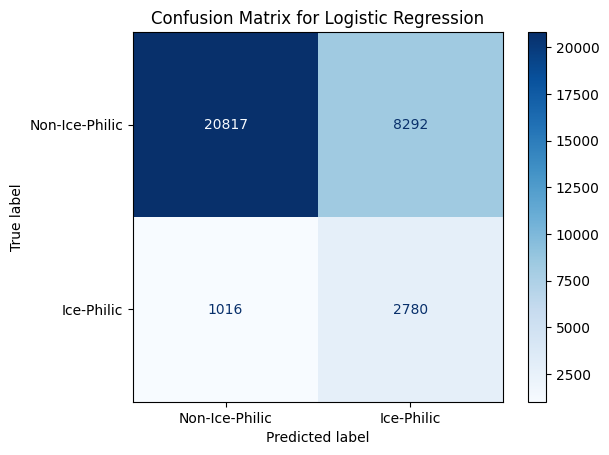

In [ ]:
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(
    best_logreg,
    X_test,
    y_test,
    display_labels=['Non-Ice-Philic', 'Ice-Philic'],
    cmap='Blues'
)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

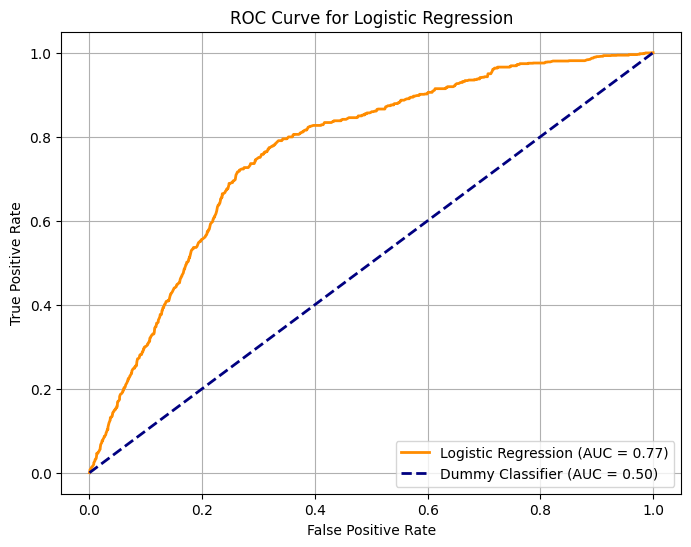

In [ ]:
# ROC Curve

# Probability scores for the positive class
y_scores_lr = best_logreg.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr_lr,
    tpr_lr,
    color='darkorange',
    lw=2,
    label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Dummy Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### c. Random Forest

**Random Forest** was selected for its ability to model non-linear relationships, making it well-suited for capturing interactions between chemical features in our dataset. Its ensemble approach ensures robustness against overfitting and improves generalization. Its feature importance output also provides valuable insights into which factors contribute most to ice-philicity.


####Hyperparameter Tuning

For Random Forest, parameters like *the number of trees, maximum tree depth,* and *minimum samples per split* were explored.

In [ ]:
# Parameter grid
param_grid_rf = {
   'n_estimators': [100, 200],
   'max_depth': [None, 10, 20],
   'max_features': ['sqrt', 'log2'],
   'min_samples_leaf': [1, 2],
   'min_samples_split': [2, 5]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for Random Forest:", grid_search_rf.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


####Prediction and Evaluation

In [ ]:
# Retrieve the best estimator
best_rf = grid_search_rf.best_estimator_

# Make predictions on the test data
y_pred_rf = best_rf.predict(X_test)

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Ice-Philic', 'Ice-Philic']))

Classification Report for Random Forest:
                precision    recall  f1-score   support

Non-Ice-Philic       0.99      0.74      0.84     29109
    Ice-Philic       0.31      0.92      0.47      3796

      accuracy                           0.76     32905
     macro avg       0.65      0.83      0.66     32905
  weighted avg       0.91      0.76      0.80     32905



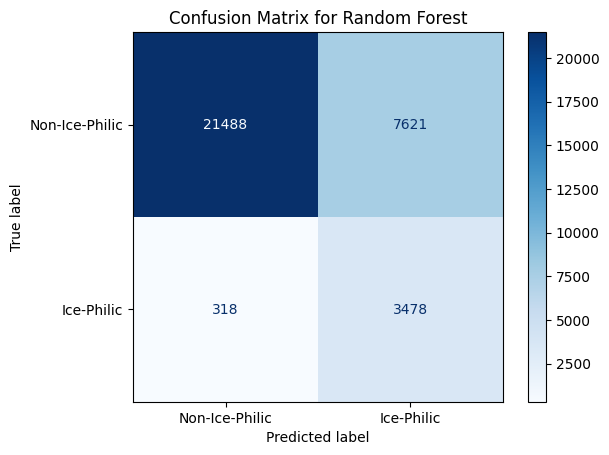

In [ ]:
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test,
    y_test,
    display_labels=['Non-Ice-Philic', 'Ice-Philic'],
    cmap='Blues'
)
plt.title("Confusion Matrix for Random Forest")
plt.show()

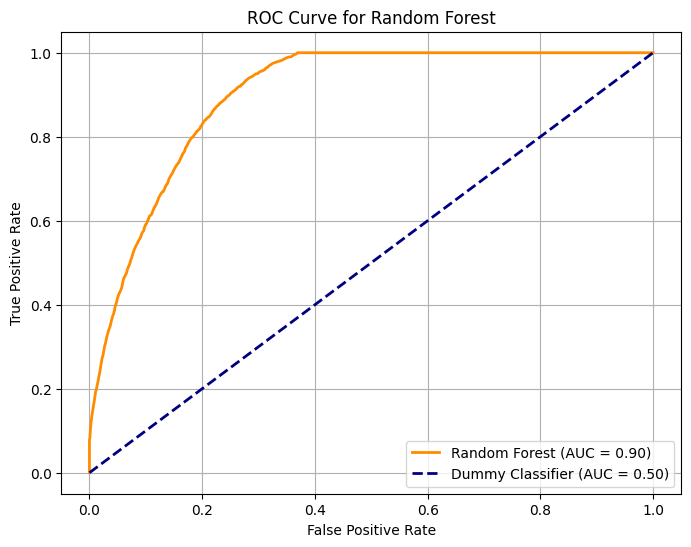

In [ ]:
# ROC Curve

# Probability scores for the positive class
y_scores_rf = best_rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr_rf,
    tpr_rf,
    color='darkorange',
    lw=2,
    label='Random Forest (AUC = %0.2f)' % roc_auc_rf
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Dummy Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Get feature importances
feature_importances = best_rf.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df.head(5))

                   Feature  Importance
64  protein_name_hepatitis    0.138122
1          absolute_charge    0.095410
0                   charge    0.086045
66  protein_name_ubiquitin    0.083802
63    protein_name_barnase    0.041022


### d. Gradient Boosting

**Gradient Boosting** was included for its iterative approach to learning, which focuses on correcting errors from previous iterations. This model is especially advantageous when dealing with imbalanced datasets as it can be fine-tuned to address class imbalance effectively, making it a strong choice for our binary classification task.


####Hyperparameter Tuning

Key hyperparameters such as *learning rate* and *maximum depth of trees* were optimized.

In [ ]:
# Parameter grid
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

# Initialize the model
gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the model
grid_search_gb.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters for Gradient Boosting:", grid_search_gb.best_params_)

Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


####Prediction and Evaluation

In [ ]:
# Retrieve the best estimator
best_gb = grid_search_gb.best_estimator_

# Make predictions on the test data
y_pred_gb = best_gb.predict(X_test)

# Classification Report
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb, target_names=['Non-Ice-Philic', 'Ice-Philic']))

Classification Report for Gradient Boosting:
                precision    recall  f1-score   support

Non-Ice-Philic       0.97      0.76      0.85     29109
    Ice-Philic       0.31      0.81      0.45      3796

      accuracy                           0.77     32905
     macro avg       0.64      0.79      0.65     32905
  weighted avg       0.89      0.77      0.81     32905



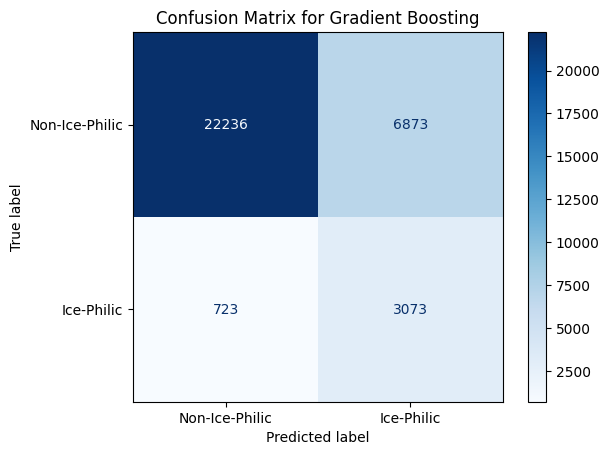

In [ ]:
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(
    best_gb,
    X_test,
    y_test,
    display_labels=['Non-Ice-Philic', 'Ice-Philic'],
    cmap='Blues'
)
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()

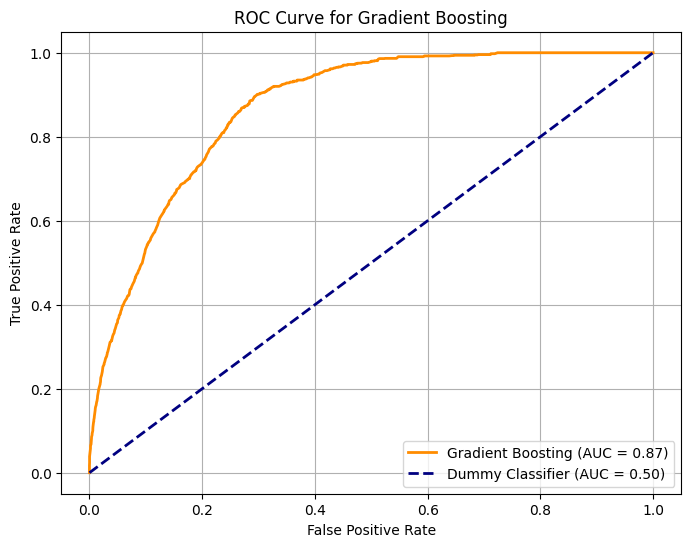

In [ ]:
# ROC Curve

# Probability scores for the positive class
y_scores_gb = best_gb.predict_proba(X_test)[:, 1]

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr_gb,
    tpr_gb,
    color='darkorange',
    lw=2,
    label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Dummy Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# Get feature importances
feature_importances = best_gb.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df.head(10))

                     Feature  Importance
64    protein_name_hepatitis    0.173856
66    protein_name_ubiquitin    0.127218
1            absolute_charge    0.062092
54               resname_THR    0.052932
0                     charge    0.051036
61       protein_name_TISAFP    0.039972
44               resname_GLU    0.035283
65  protein_name_hydrophobin    0.025606
40               resname_ASN    0.023885
56               resname_TYR    0.022663


##IV. Model Comparison and Results

In this section, we evaluate and compare the performance of our models across multiple metrics to determine their strengths and weaknesses. The models assessed include the Dummy Classifier (baseline), Logistic Regression, Random Forest, and Gradient Boosting.

###Performance Metrics Overview

The performance metrics considered are **Accuracy, F1 Score, Precision, Recall, and ROC AUC**. These metrics provide a comprehensive view of each model's predictive ability and balance between correctly identifying ice-philic cases and avoiding false positives.

From the dataframe, both **Random Forest** and **Gradient Boosting** stand out as the best-performing models, with Gradient Boosting achieving the highest overall accuracy of 77% and Random Forest excelling in Recall at 0.92. Logistic Regression performed better than the Dummy Classifier but struggled to fully capture the complexity of the data.

In [ ]:
results = []

def evaluate_model(name, y_test, y_pred, y_scores):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': auc(*roc_curve(y_test, y_scores)[:2])
    })

# Dummy Classifier
evaluate_model("Dummy Classifier", y_test, dummy_pred, y_scores_lr)

# Logistic Regression
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_scores_lr)

# Random Forest
evaluate_model("Random Forest", y_test, y_pred_rf, y_scores_rf)

# Gradient Boosting
evaluate_model("Gradient Boosting", y_test, y_pred_gb, y_scores_gb)

print("Model Performance Comparison:")
results_df = pd.DataFrame(results)
results_df = results_df.round(2)
print(results_df)

Model Performance Comparison:
                 Model  Accuracy  F1 Score  Precision  Recall  ROC AUC
0     Dummy Classifier      0.50      0.19       0.12    0.51     0.77
1  Logistic Regression      0.72      0.37       0.25    0.73     0.77
2        Random Forest      0.76      0.47       0.31    0.92     0.90
3    Gradient Boosting      0.77      0.45       0.31    0.81     0.87


###Visualizations

**1. F1 Score Bar Chart**


*   This bar chart compares the F1 Scores across all models, highlighting their ability to balance precision and recall.
*   The Dummy Classifier's low score of 0.19 reinforces the need for advanced models. Random Forest and Gradient Boosting performed much better, with Gradient Boosting slightly more balanced overall.

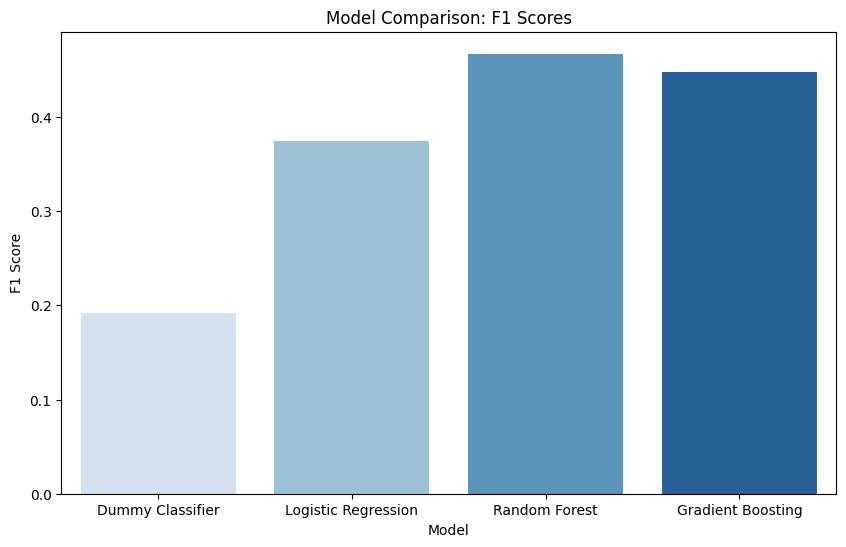

In [ ]:
plt.figure(figsize=(10, 6))
results_df['Model Type'] = results_df['Model']
sns.barplot(
    x="Model",
    y="F1 Score",
    hue="Model Type",
    data=results_df,
    palette="Blues",
    dodge=False
)
plt.title("Model Comparison: F1 Scores")
plt.show()

**2. Combined ROC Curve**


*   The combined ROC curve visualizes the trade-off between True Positive Rate and False Positive Rate for each model.
*   Random Forest achieves the highest AUC of 0.90, followed by Gradient Boosting at 0.87. Logistic Regression had an AUC of 0.77 similar to the Dummy Classifier reflecting its limitations in capturing the complexity of the data.

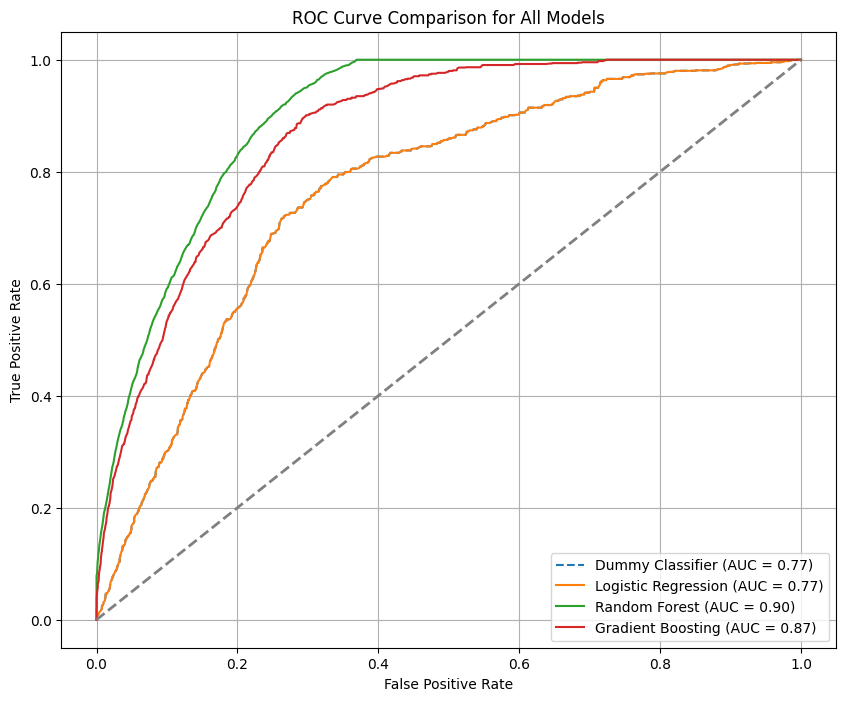

In [ ]:
plt.figure(figsize=(10, 8))

# Dummy Classifier
plt.plot(fpr_lr, tpr_lr, linestyle='--', label='Dummy Classifier (AUC = {:.2f})'.format(roc_auc_lr))

# Logistic Regression
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))

# Random Forest
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))

# Gradient Boosting
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = {:.2f})'.format(roc_auc_gb))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.title('ROC Curve Comparison for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**3. Confusion Matrices**


*   The confusion matrices show how many cases each model predicted correctly and where they made mistakes.
*   These matrices highlight how Random Forest prioritizes minimizing false negatives, whereas Gradient Boosting balances false negatives and false positives more effectively.


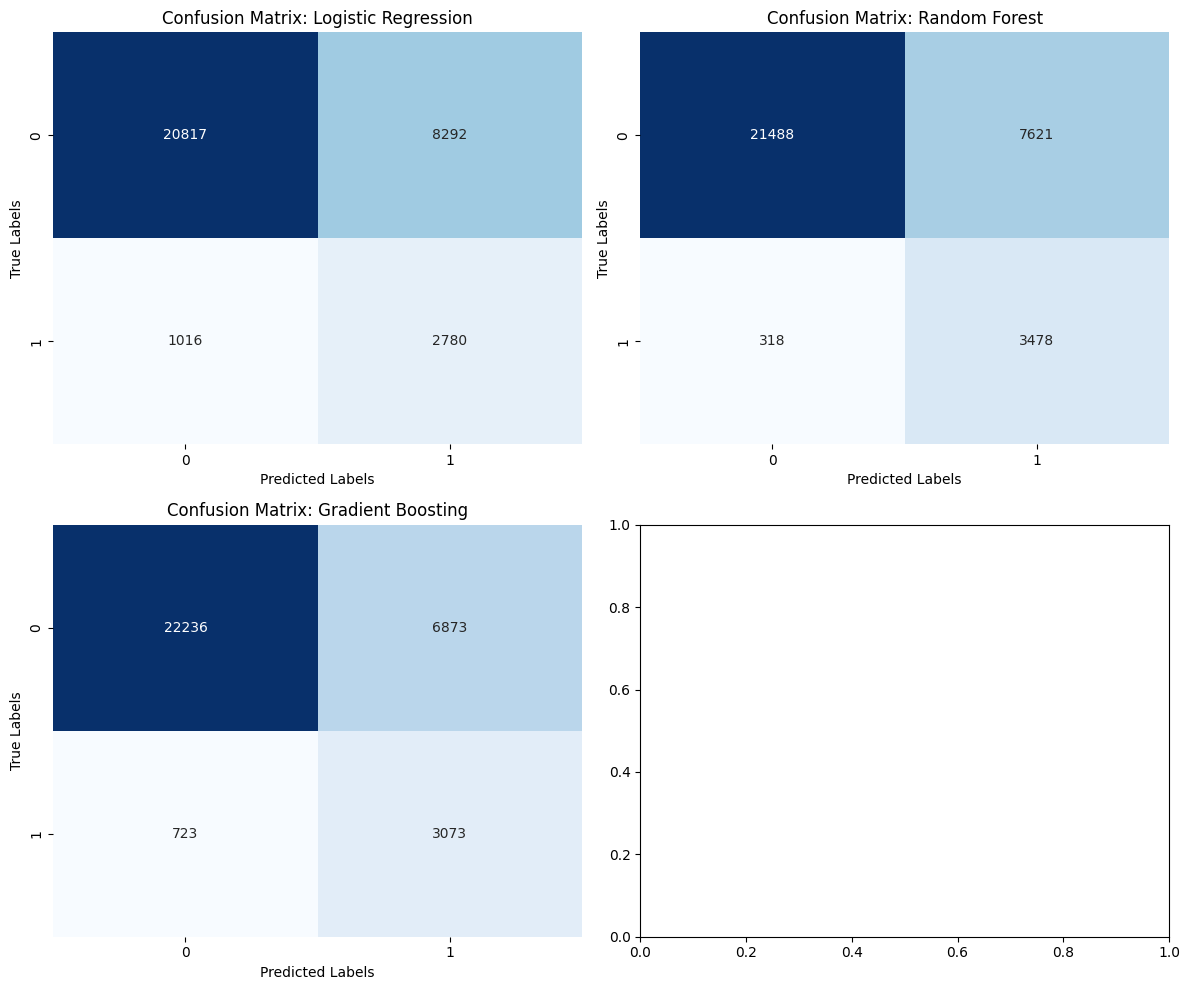

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = [
    ("Logistic Regression", y_test, y_pred_lr),
    ("Random Forest", y_test, y_pred_rf),
    ("Gradient Boosting", y_test, y_pred_gb),
]

for ax, (name, y_true, y_pred) in zip(axes.flatten(), models):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

**4. Feature Importance**


*   For Random Forest and Gradient Boosting, we looked at the top 10 features that contributed most to predictions.
*   Features such as protein_name_hepatitis, absolute_charge, and charge consistently appear as highly influential.



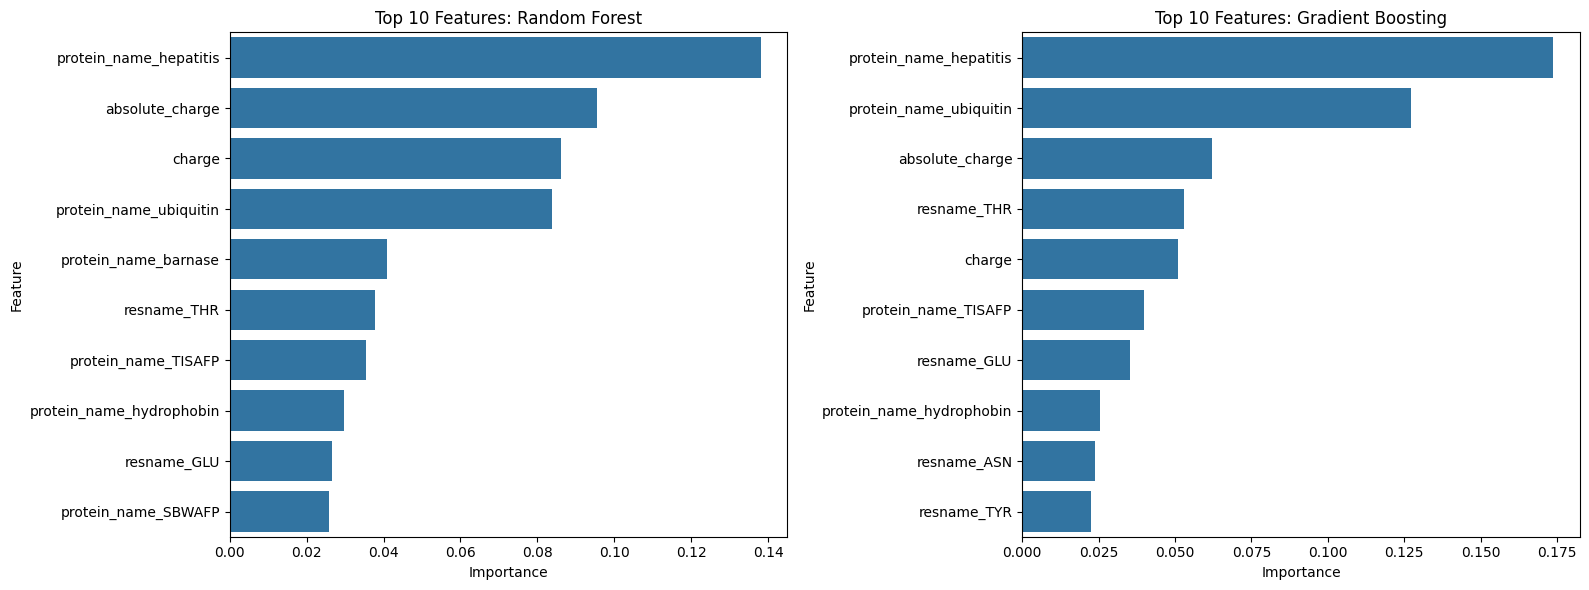

In [ ]:
# Visualize the top 10 important features

# Retrieve feature importance
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

gb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
sns.barplot(data=rf_importances.head(10), x='Importance', y='Feature', ax=axes[0])
axes[0].set_title('Top 10 Features: Random Forest')

# Gradient Boosting
sns.barplot(data=gb_importances.head(10), x='Importance', y='Feature', ax=axes[1])
axes[1].set_title('Top 10 Features: Gradient Boosting')

plt.tight_layout()
plt.show()


###Key Takeaways



*   **Logistic Regression** improves significantly over the Dummy Classifier but struggles with a high false positive rate.

*   **Random Forest** excels in Recall which makes it highly effective at capturing ice-philic cases and minimizing false negatives.

*   **Gradient Boosting** provides a strong balance across Precision and Recall, making it reliable choice.




##V. Hypothesis Testing

### Read and Load Data

*This part is slightly overlap with the data loading part in the beginning of this notebook because the "Hypothesis Testing" section requires significant RAM due to the size of the dataset and computational complexity. While one teammate with a high-RAM system successfully ran this section, Google Colab lacks sufficient memory. To ensure clarity and reproducibility, we kept overlapping data loading code in the notebook for this section.*

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.spatial.distance import pdist

In [ ]:
os.getcwd()

'D:\\gdrive\\My Drive\\gdrive\\CIS545'

In [ ]:
# data_dir = '/content/drive/MyDrive/gdrive/CIS545/data'
data_dir = 'D:\\gdrive\\My Drive\\gdrive\\CIS545/data'

# Load all CSV files from the directory
all_files = glob.glob(os.path.join(data_dir, "*.csv"))

expected_columns = [
    "atom_number", "atom_name", "resname", "charge", "x", "y", "z",
    "protein_name", "betaphi", "ice_philic", "neighbor"
]

# Combine all files into a single DataFrame
df_list = []
for file in all_files:
  df = pd.read_csv(file)
  file_name = os.path.basename(file)

  if sorted(df.columns) != sorted(expected_columns):
        raise ValueError(f"File '{file_name}' does not match the expected columns!")

  df = df[expected_columns]
  df_list.append(df)
  print(f'Protein Data "{file_name}" have shape {df.shape}')

Protein Data "LPAFP.csv" have shape (8416, 11)
Protein Data "TMAFP.csv" have shape (5804, 11)
Protein Data "SBWAFP.csv" have shape (9334, 11)
Protein Data "ubiquitin.csv" have shape (10310, 11)
Protein Data "barnase.csv" have shape (14872, 11)
Protein Data "TISAFP.csv" have shape (13324, 11)
Protein Data "OPAFP.csv" have shape (6144, 11)
Protein Data "COLAFP.csv" have shape (14348, 11)
Protein Data "hydrophobin.csv" have shape (8224, 11)
Protein Data "hepatitis.csv" have shape (18906, 11)


In [ ]:
# combine all protein data into a single DataFrame
data = pd.concat(df_list, ignore_index=True)
print(f'Data shape of the combined dataset: {data.shape}')
data.head(5)

Data shape of the combined dataset: (109682, 11)


,atom_number,atom_name,resname,charge,x,y,z,protein_name,betaphi,ice_philic,neighbor
0,0,N,PRO,-0.202,42.199997,35.989998,45.01,LPAFP,1.98,False,1
1,0,N,PRO,-0.202,42.199997,35.989998,45.01,LPAFP,1.98,False,2
2,0,N,PRO,-0.202,42.199997,35.989998,45.01,LPAFP,1.98,False,3
3,0,N,PRO,-0.202,42.199997,35.989998,45.01,LPAFP,1.98,False,4
4,0,N,PRO,-0.202,42.199997,35.989998,45.01,LPAFP,1.98,False,5


### Post-processing

In [ ]:
# drop neighbors
data = data.drop(columns=["neighbor"])
data = data.drop_duplicates()
data = data.reset_index(drop=True)

print(f'Data shape of the combined dataset: {data.shape}')
data.head(5)

Data shape of the combined dataset: (5266, 10)


,atom_number,atom_name,resname,charge,x,y,z,protein_name,betaphi,ice_philic
0,0,N,PRO,-0.202,42.199997,35.989998,45.010000,LPAFP,1.98,False
1,1,CD,PRO,-0.012,41.390000,35.010000,45.760002,LPAFP,1.99,False
2,2,CG,PRO,-0.121,40.840000,35.860000,46.910000,LPAFP,1.98,False
3,3,CB,PRO,-0.115,40.500000,37.170000,46.199997,LPAFP,1.98,False
4,4,CA,PRO,0.100,41.370003,37.130000,44.930000,LPAFP,1.97,False


In [ ]:
#get the first letter of the atom_name
data['atom_name'] = data['atom_name'].str[0]
print(data['atom_name'].unique())
print(data['atom_name'].value_counts())

['N' 'C' 'O' 'S']
C    3272
O    1122
N     856
S      16
Name: atom_name, dtype: int64


In [ ]:
contingency_table = pd.crosstab(data['atom_name'], data['ice_philic'])
print(contingency_table)

ice_philic  False  True 
atom_name               
C            2864    408
N             759     97
O            1005    117
S              14      2


### Hypothesis 1: Atom name will affect Ice-philicity

In [ ]:
contingbency_table = pd.crosstab(data['atom_name'], data['ice_philic'])
print(contingency_table)

ice_philic  False  True 
atom_name               
C            2864    408
N             759     97
O            1005    117
S              14      2


In [ ]:
#Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies:")
# print(expected)

# Interpretation
if p < 0.05/4:
    print("Reject the null hypothesis: There is an association between atom_name and ice_philic.")
else:
    print("Fail to reject the null hypothesis: No significant association between atom_name and ice_philic.")

Chi-Squared Statistic: 3.6010940901480244
P-value: 0.307885304617202
Degrees of Freedom: 3
Fail to reject the null hypothesis: No significant association between atom_name and ice_philic.


### Hypothesis 2: Resname will affect Ice-philicity

In [ ]:
contingency_table = pd.crosstab(data['resname'], data['ice_philic'])
print(contingency_table)

ice_philic  False  True 
resname                 
ALA           263     35
ARG           206     43
ASN           384     43
ASP           359     35
CYS            60     11
GLN           215     19
GLU           264     15
GLY           309     17
HIS            66      8
ILE           157     31
LEU           252     47
LYS           295     18
MET            57      7
PHE           108     14
PRO           265     37
SER           377     50
THR           561    136
TRP            30     17
TYR           199     17
VAL           215     24


In [ ]:
# Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies:")
# print(expected)

# Interpretation
if p < 0.05/4:
    print("Reject the null hypothesis: There is an association between resname and ice_philic.")
else:
    print("Fail to reject the null hypothesis: No significant association between resname and ice_philic.")

Chi-Squared Statistic: 129.88869154917847
P-value: 1.5304722208967705e-18
Degrees of Freedom: 19
Reject the null hypothesis: There is an association between resname and ice_philic.


In [ ]:
# Let's see what residues are the most influencial to the icephilicity by looking at the residual
observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)

# Add residuals to the contingency table for better interpretation
residuals_df = pd.DataFrame(
    standardized_residuals,
    index=contingency_table.index,
    columns=contingency_table.columns
)

# top 10 residue's residuals
top_residuals = residuals_df.abs().stack().nlargest(10)

In [ ]:
top_residuals_indices = top_residuals.index.tolist()
top_residuals_values = top_residuals.values

print("Top 10 Residual Values and Associated Categories:")
for i in range(10):
    resname, ice_philic_value = top_residuals_indices[i]
    residual_value = top_residuals_values[i]
    print(f"{i + 1}. Resname: '{resname}', Ice_Philic: {ice_philic_value}, Residual: {residual_value:.2f}")

Top 10 Residual Values and Associated Categories:
1. Resname: 'THR', Ice_Philic: True, Residual: 5.88
2. Resname: 'TRP', Ice_Philic: True, Residual: 4.84
3. Resname: 'GLY', Ice_Philic: True, Residual: 3.48
4. Resname: 'GLU', Ice_Philic: True, Residual: 3.14
5. Resname: 'LYS', Ice_Philic: True, Residual: 3.13
6. Resname: 'ARG', Ice_Philic: True, Residual: 2.48
7. Resname: 'THR', Ice_Philic: False, Residual: 2.15
8. Resname: 'LEU', Ice_Philic: True, Residual: 1.94
9. Resname: 'ILE', Ice_Philic: True, Residual: 1.85
10. Resname: 'TRP', Ice_Philic: False, Residual: 1.78


### Hypothesis 3: Polarity will affect Ice-philicity

In [ ]:
data['abs_charge'] = np.abs(data['charge'])
data['polarity'] = data['abs_charge'].apply(lambda x: True if x > 0.26 else False)

contingency_table = pd.crosstab(data['polarity'], data['ice_philic'])
print(contingency_table)

ice_philic  False  True 
polarity                
False        1793    248
True         2849    376


In [ ]:
#Perform the Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies:")
# print(expected)

# Interpretation
if p < 0.05/4:
    print("Reject the null hypothesis: There is an association between polarity and ice_philic.")
else:
    print("Fail to reject the null hypothesis: No significant association between polarity and ice_philic.")

Chi-Squared Statistic: 0.24446773071851413
P-value: 0.6209977431719768
Degrees of Freedom: 1
Fail to reject the null hypothesis: No significant association between polarity and ice_philic.


### Hypothesis 4: Icephilic atoms would clustered together

In [ ]:
# Function to calculate pairwise distances for ice-philic and ice-phobic within each protein
def compute_distances_within_protein(group, chunk_size=500):
    positions = group[['x', 'y', 'z']].values
    labels = group['ice_philic'].values
    distances = pdist(positions)  # Pairwise distances
    pair_indices = np.triu_indices(len(labels), k=1)
    label_pairs = [(labels[i], labels[j]) for i, j in zip(pair_indices[0], pair_indices[1])]
    return distances, label_pairs

In [ ]:
# Separate pairwise distances by state within each protein
ice_philic_distances = []
ice_phobic_distances = []

for protein_id, group in data.groupby('protein_name'):
    distances, label_pairs = compute_distances_within_protein(group)
    for d, (label1, label2) in zip(distances, label_pairs):
        if label1 == 1 and label2 == 1:  # Both atoms are ice-philic
            ice_philic_distances.append(d)
        elif label1 == 0 and label2 == 0:  # Both atoms are ice-phobic
            ice_phobic_distances.append(d)

In [ ]:
print(f"Ice-philic mean distance: {np.mean(ice_philic_distances):.2f}")
print(f"Ice-phobic mean distance: {np.mean(ice_phobic_distances):.2f}")

# Observed statistic: Difference in mean pairwise distances
observed_statistic = np.mean(ice_philic_distances) - np.mean(ice_phobic_distances)
print(observed_statistic)

Ice-philic mean distance: 15.89
Ice-phobic mean distance: 22.70
-6.8121044924336935


In [ ]:
# Bootstrapping
n_iterations = 10000
bootstrap_statistics = []

# Combine all distances and labels
all_distances = np.concatenate([ice_philic_distances, ice_phobic_distances])
all_labels = np.concatenate([np.ones(len(ice_philic_distances)), np.zeros(len(ice_phobic_distances))])

np.random.seed(42)  # For reproducibility
for _ in range(n_iterations):
    # Shuffle labels
    shuffled_labels = np.random.permutation(all_labels)

    # Split into two groups based on shuffled labels
    group_1_distances = all_distances[shuffled_labels == 1]
    group_0_distances = all_distances[shuffled_labels == 0]

    # Compute the difference in mean distances
    bootstrap_statistic = np.mean(group_1_distances) - np.mean(group_0_distances)
    bootstrap_statistics.append(bootstrap_statistic)


In [ ]:
# Calculate p-value
bootstrap_statistics = np.array(bootstrap_statistics)
p_value = np.mean(bootstrap_statistics <= observed_statistic)

# Results
print(f"Observed Statistic (Mean Distance Difference): {observed_statistic}")
print(f"P-Value (Bootstrap): {p_value}")

if p_value < 0.05/4:
    print("Reject the null hypothesis: Ice-philic atoms are significantly more clustered.")
else:
    print("Fail to reject the null hypothesis: No significant clustering of ice-philic atoms.")

Observed Statistic (Mean Distance Difference): -6.8121044924336935
P-Value (Bootstrap): 0.0
Reject the null hypothesis: Ice-philic atoms are significantly more clustered.


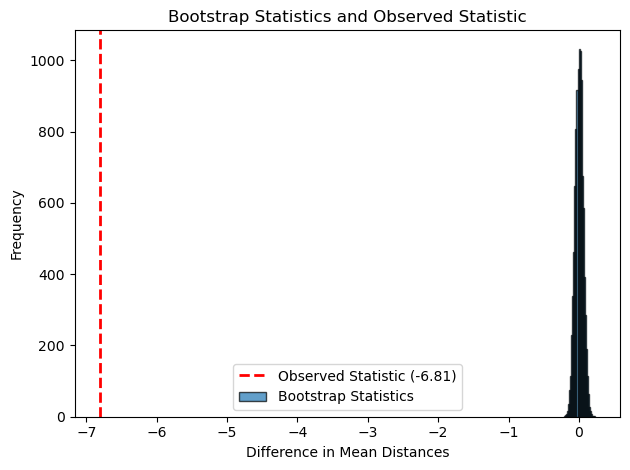

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram of bootstrap statistics
plt.hist(bootstrap_statistics, bins=30, alpha=0.7, edgecolor='black', label='Bootstrap Statistics')

# Add a vertical line for the observed statistic
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label=f'Observed Statistic ({observed_statistic:.2f})')

# Label the plot
plt.title('Bootstrap Statistics and Observed Statistic')
plt.xlabel('Difference in Mean Distances')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Based on the analysis above, we can conclude for the hypothesis testing results:
* Hypothesis 1: Fail to reject the null hypothesis
    
    * Atom type will not affect ice-philic
    * No significant association between atom type and ice-philic

* Hypothesis 2: Reject the null hypothesis
    
    * Resname will affect ice-philic
    * There is an association between resname and ice-philic while "Threonine" has the highest correlation with the ice-philicity

* Hypothesis 3: Fail to reject the null hypothesis
    
    * Polarity will not affect ice-philic
    * No significant association between polarity and ice-philic

* Hypothesis 4: Reject the null hypothesis
    
    * Ice-philic atoms will cluster together
    * Ice-philic atoms are significantly more clustered


##VI. Conclusion

To predict protein ice-philicity, we relied solely on chemical information. However, protein atoms possess both chemical and spatial information. Incorporating spatial information requires specialized approaches. For instance, in AlphaFold, which predicts protein structure from its sequence, spatial embeddings are used to capture topographical relationships, including pairwise distances, angles, dihedrals, and neighboring residues.

In future work, we aim to integrate spatial information alongside chemical information using Graph Neural Networks (GNNs) or Transformers to develop a more robust model for predicting ice-philicity. This model would process protein-specific inputs, accommodating the varying feature lengths of different proteins. Both GNNs and Transformers are well-suited to handle this variability and embed the information into a meaningful vector space.

Generating protein data is computationally intensive. Simulating a single protein requires approximately 400 hours of computing power using 32 threads. Acquiring accurate and abundant protein data is thus a significant challenge.

Predicting the ice-philicity of proteins from their structure can be modular. For example, our model could be extended to predict protein binding sites, which would have valuable applications in drug discovery.